# Solve 2d Poisson equation by PINN

### Domain:  $D=[0,1]^2$ 
### PDE
$$
\begin{aligned}
   \Delta u =& f\,\quad \mbox{in}\, D \\
   u|_{\partial D} =& g
   \end{aligned}
$$

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import math 
import torch.nn as nn
from sklearn.model_selection import train_test_split 
import random
import itertools 
from tqdm import tqdm
import os
import time

### functions f and g in the PDE, defined using the reference solution (see below).

In [2]:
def laplacian(model, x):
    u = model(x)
    
    u_x = torch.autograd.grad(
            u.sum(), x,
            retain_graph=True,
            create_graph=True
        )[0]
    
    u_xx = 0 
    for i in range(2):
        u_xx += torch.autograd.grad(
                 u_x[:,i].sum(), x,
                 retain_graph=True,
                 create_graph=True
             )[0][:,i:i+1]
    return u_xx

def f(x):    
    return laplacian(ref_u, x)    
def g(x):
    return ref_u(x)

### function to define a feedforward neural network

In [3]:
def create_sequential_nn(layer_dims, activation=torch.nn.Tanh()):
    layers = torch.nn.Sequential()
    for i in range(len(layer_dims)-2) :
        layers.add_module(f'{i+1}',torch.nn.Linear(layer_dims[i], layer_dims[i+1])) 
        layers.add_module(f'acti {i+1}', activation)
    layers.add_module('last', torch.nn.Linear(layer_dims[-2], layer_dims[-1])) 
    return layers

## Loss functions:

### PDE loss:     $\frac{1}{n} \sum_{i=1}^n |\Delta u(X_i)-f(X_i))|^2$

### Boundary loss :    $\frac{1}{m} \sum_{i=1}^m |u(Y_i)-g(Y_i))|^2$


In [4]:
def pde_loss(model, x):
    u_xx = laplacian(model, x)
    return ((u_xx - f(x))**2).mean()

def boundary_loss(model, x):
    u = model(x)
    return ((u-g(x))**2).mean()

### Prepare data $X$ in domain $D$ and data $Y$ on the boundary $\partial D$ 

In [5]:
def sample_data_domain(size):
    return np.random.rand(size, 2) 

def sample_data_boundary(size_each_bndry):
    # left boundary
    data_whole = np.column_stack([np.zeros(size_each_bndry), np.random.rand(size_each_bndry)]) 
    # right boundary
    data = np.column_stack([np.ones(size_each_bndry), np.random.rand(size_each_bndry)]) 
    data_whole = np.concatenate([data_whole, data])
    # top boundary
    data = np.column_stack([np.random.rand(size_each_bndry),np.ones(size_each_bndry)]) 
    data_whole = np.concatenate([data_whole, data])   
    # bottom boundary
    data = np.column_stack([np.random.rand(size_each_bndry),np.zeros(size_each_bndry)])     
    data_whole = np.concatenate([data_whole, data])
    
    return data_whole

### Training function

In [6]:
    def train(model, X, Y, optimizer, learning_rate, batch_size_X, batch_size_Y, num_iters, alpha):
        """Function to train the model
        """
         
        # --- start the training over the required number of epochs ---
        train_losses = []
        
        print ("\ntraining starts, %d iterations in total." % num_iters) 
        rng = np.random.default_rng()
        for iter in tqdm(range(num_iters)):
            # Train the model by going through the whole dataset
            batch_idx_X = rng.integers(X.shape[0], size=batch_size_X)
            batch_idx_Y = rng.integers(Y.shape[0], size=batch_size_Y)
            
            X_batch = torch.tensor(X[batch_idx_X, :], requires_grad=True).float()
            Y_batch = torch.tensor(Y[batch_idx_Y, :]).float()
            
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
           
            loss1 = pde_loss(model, X_batch)
            loss2 = boundary_loss(model, Y_batch)

            loss = loss1 + alpha * loss2
            # Get gradient with respect to parameters of the model
            loss.backward()
            # Store loss
            loss3 = ((model(X_batch) - ref_u(X_batch))**2).mean()

            train_losses.append([loss.detach().item(), loss1.detach().item(), loss2.detach().item(), loss3.detach().item()])
            # Updating parameters
            optimizer.step()
        print ("training ends.\n") 
        return model, train_losses

### Set parameters

In [7]:
n = 10000
n_bndry = 1000
batch_size = 100
batch_size_bndry = 100
alpha = 5.0
num_iters = 3000
layer_dims = [2, 20, 20, 20, 1] 
optimizer_name = 'Adam'
learning_rate = 0.01

# This parameter affects the magnitude of the gradients of the solution.
# Increasing its value makes the training more difficult.
ref_u_coeff = 5.0

# Reference solution
class ref_u_nn(nn.Module):
    def forward(self, x):
        return (x[:,0]**2 + 3.0 * torch.sin(x[:,1] * ref_u_coeff)).reshape((-1,1))  

ref_u = ref_u_nn()

# create neural network
model = create_sequential_nn(layer_dims)

# prepare data
X = sample_data_domain(n)
Y = sample_data_boundary(n_bndry)

# prepare optimizer
if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Start training

In [8]:
trained_model, loss_list = train(model, X, Y, optimizer, learning_rate, batch_size, batch_size_bndry, num_iters, alpha)
loss_list = np.array(loss_list)


training starts, 3000 iterations in total.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 452.50it/s]

training ends.



### Plot 

Losses:


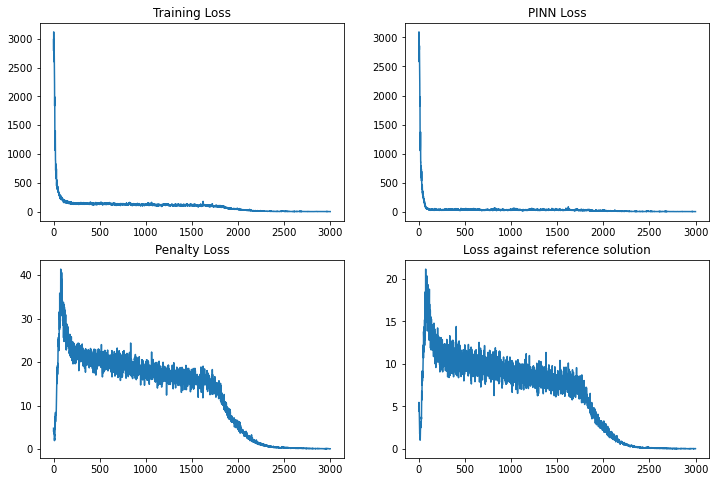

Solution u:


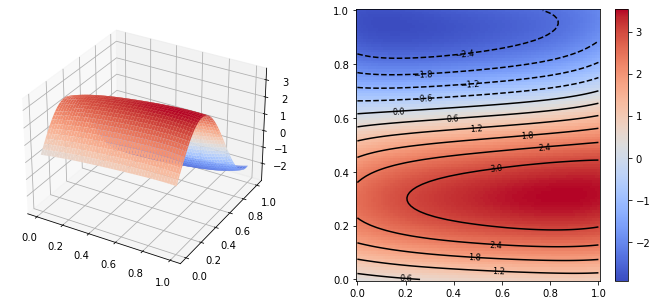

In [9]:
ngrid = 100
grid1d = np.linspace(0, 1.0, ngrid)
x_plot = np.outer(grid1d, np.ones(ngrid)) 
y_plot = np.outer(grid1d, np.ones(ngrid)).T 

x2d = torch.from_numpy(np.concatenate((x_plot.reshape(ngrid * ngrid, 1), y_plot.reshape(ngrid * ngrid, 1)), axis=1)).float()
u = trained_model(x2d).detach().numpy()

u = u.reshape(ngrid, ngrid)

print ('Losses:')
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0,0].plot(loss_list[:,0])
ax[0,0].set_title('Training Loss')
ax[0,1].plot(loss_list[:,1])
ax[0,1].set_title('PINN Loss')
ax[1,0].plot(loss_list[:,2])
ax[1,0].set_title('Penalty Loss')
ax[1,1].plot(loss_list[:,3])
ax[1,1].set_title('Loss against reference solution')

plt.show()
fig_name = f'losses.jpg'
fig.savefig(fig_name)
plt.close()

print ('Solution u:')

fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2)  
ax0.plot_surface(x_plot, y_plot, u, cmap='coolwarm', edgecolor='none')
im = ax1.pcolormesh(x_plot, y_plot, u, cmap='coolwarm',shading='auto')
contours = ax1.contour(x_plot, y_plot, u, 10, colors='black')
ax1.clabel(contours, inline=False, fontsize=8)
fig.colorbar(im, ax=ax1)
fig_name = f'u.jpg'
fig.savefig(fig_name)
plt.show()
#plt.close()
